In [1]:
import gym
import torch
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import nn

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # 4 input features (cartpole state), 128 neurons in hidden layer
        self.fc2 = nn.Linear(128, output_dim)  # 128 neurons in hidden layer, 2 output (left or right)

        # Apply the weights initialization
        self.apply(self.weights_init)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            # nn.init.xavier_uniform_(m.weight)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

    def inject_parameters(self, pvec):
        new_state_dict = {}
        count = 0
        for name, param in self.named_parameters():
            sz = param.data.numel()
            raw = pvec[count:count + sz]
            reshaped = raw.reshape(param.data.shape)
            new_state_dict[name] = torch.from_numpy(reshaped).float()
            count += sz
        self.load_state_dict(new_state_dict)

In [3]:
def get_policy(model, state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = model(state)
    return probs.detach().numpy()

In [4]:
env = gym.make('CartPole-v1')

# Number of episodes
n_episodes = 1000

# Create the model
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
model = PolicyNetwork(input_dim, output_dim)
current_output = None
history = list()

/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
for episode in range(n_episodes):
    # Reset the environment
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
    
        if episode == 0 and current_output is None:
            prev_output = torch.tensor([0.5, 0.5])
        else:
            prev_output = current_output.detach()
            
        # Get the original parameters
        current_param = torch.cat([param.view(-1) for param in model.parameters()])

        # Perturb the model parameters
        delta = torch.randn_like(current_param)
            
        # Forward pass to calculate the output
        current_output = model(torch.from_numpy(state).float().unsqueeze(0))

        # Calculate the error
        error = ((current_output - prev_output)**2).mean()
        
        # Clear the gradients from the last backward pass
        model.zero_grad()
        
        # Backward pass to calculate the gradients
        error.backward()

        # Extract the gradients
        gradient = torch.cat([param.grad.view(-1) for param in model.parameters()])
        
        # Normalize the gradients
        gradient /= (gradient.sum() + 1e-10)

        # Calculate the new parameters
        new_param = current_param + delta * gradient
        
        # Inject the new parameters into the model
        model.inject_parameters(new_param.detach().numpy())
         
        action = torch.argmax(model(torch.from_numpy(state).float().unsqueeze(0))).item()
        state, reward, done, _ = env.step(action)
        total_reward += reward
        
    history.append(total_reward)

    print(f"Episode {episode+1}, Total Reward: {total_reward}")

env.close()

/Users/jinhyunpark/miniforge3/envs/tilda/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1, Total Reward: 18.0
Episode 2, Total Reward: 14.0
Episode 3, Total Reward: 29.0
Episode 4, Total Reward: 38.0
Episode 5, Total Reward: 10.0
Episode 6, Total Reward: 9.0
Episode 7, Total Reward: 13.0
Episode 8, Total Reward: 10.0
Episode 9, Total Reward: 12.0
Episode 10, Total Reward: 11.0
Episode 11, Total Reward: 10.0
Episode 12, Total Reward: 9.0
Episode 13, Total Reward: 9.0
Episode 14, Total Reward: 9.0
Episode 15, Total Reward: 9.0
Episode 16, Total Reward: 9.0
Episode 17, Total Reward: 10.0
Episode 18, Total Reward: 8.0
Episode 19, Total Reward: 9.0
Episode 20, Total Reward: 9.0
Episode 21, Total Reward: 10.0
Episode 22, Total Reward: 8.0
Episode 23, Total Reward: 9.0
Episode 24, Total Reward: 10.0
Episode 25, Total Reward: 9.0
Episode 26, Total Reward: 9.0
Episode 27, Total Reward: 8.0
Episode 28, Total Reward: 10.0
Episode 29, Total Reward: 9.0
Episode 30, Total Reward: 8.0
Episode 31, Total Reward: 8.0
Episode 32, Total Reward: 10.0
Episode 33, Total Reward: 9.0
Epis

Episode 311, Total Reward: 10.0
Episode 312, Total Reward: 9.0
Episode 313, Total Reward: 10.0
Episode 314, Total Reward: 9.0
Episode 315, Total Reward: 10.0
Episode 316, Total Reward: 9.0
Episode 317, Total Reward: 9.0
Episode 318, Total Reward: 9.0
Episode 319, Total Reward: 9.0
Episode 320, Total Reward: 9.0
Episode 321, Total Reward: 9.0
Episode 322, Total Reward: 10.0
Episode 323, Total Reward: 9.0
Episode 324, Total Reward: 9.0
Episode 325, Total Reward: 8.0
Episode 326, Total Reward: 10.0
Episode 327, Total Reward: 10.0
Episode 328, Total Reward: 9.0
Episode 329, Total Reward: 10.0
Episode 330, Total Reward: 9.0
Episode 331, Total Reward: 9.0
Episode 332, Total Reward: 10.0
Episode 333, Total Reward: 9.0
Episode 334, Total Reward: 10.0
Episode 335, Total Reward: 9.0
Episode 336, Total Reward: 9.0
Episode 337, Total Reward: 10.0
Episode 338, Total Reward: 9.0
Episode 339, Total Reward: 10.0
Episode 340, Total Reward: 9.0
Episode 341, Total Reward: 10.0
Episode 342, Total Reward: 

Episode 638, Total Reward: 9.0
Episode 639, Total Reward: 9.0
Episode 640, Total Reward: 9.0
Episode 641, Total Reward: 8.0
Episode 642, Total Reward: 10.0
Episode 643, Total Reward: 8.0
Episode 644, Total Reward: 10.0
Episode 645, Total Reward: 8.0
Episode 646, Total Reward: 10.0
Episode 647, Total Reward: 8.0
Episode 648, Total Reward: 10.0
Episode 649, Total Reward: 10.0
Episode 650, Total Reward: 10.0
Episode 651, Total Reward: 10.0
Episode 652, Total Reward: 9.0
Episode 653, Total Reward: 9.0
Episode 654, Total Reward: 9.0
Episode 655, Total Reward: 9.0
Episode 656, Total Reward: 10.0
Episode 657, Total Reward: 10.0
Episode 658, Total Reward: 10.0
Episode 659, Total Reward: 10.0
Episode 660, Total Reward: 9.0
Episode 661, Total Reward: 9.0
Episode 662, Total Reward: 8.0
Episode 663, Total Reward: 9.0
Episode 664, Total Reward: 10.0
Episode 665, Total Reward: 8.0
Episode 666, Total Reward: 8.0
Episode 667, Total Reward: 10.0
Episode 668, Total Reward: 9.0
Episode 669, Total Reward:

Episode 977, Total Reward: 9.0
Episode 978, Total Reward: 10.0
Episode 979, Total Reward: 10.0
Episode 980, Total Reward: 9.0
Episode 981, Total Reward: 8.0
Episode 982, Total Reward: 9.0
Episode 983, Total Reward: 9.0
Episode 984, Total Reward: 10.0
Episode 985, Total Reward: 9.0
Episode 986, Total Reward: 10.0
Episode 987, Total Reward: 8.0
Episode 988, Total Reward: 9.0
Episode 989, Total Reward: 9.0
Episode 990, Total Reward: 10.0
Episode 991, Total Reward: 10.0
Episode 992, Total Reward: 9.0
Episode 993, Total Reward: 10.0
Episode 994, Total Reward: 10.0
Episode 995, Total Reward: 10.0
Episode 996, Total Reward: 8.0
Episode 997, Total Reward: 10.0
Episode 998, Total Reward: 8.0
Episode 999, Total Reward: 10.0
Episode 1000, Total Reward: 9.0


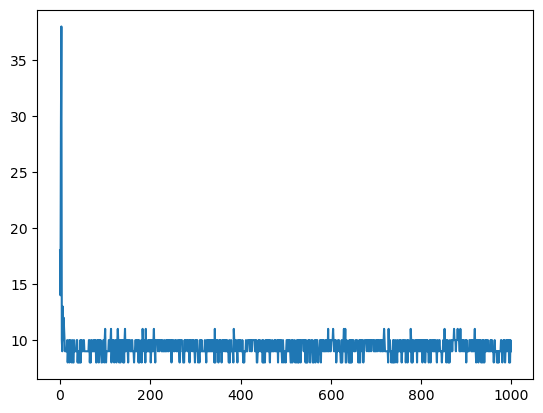

In [6]:
plt.plot(np.arange(n_episodes), history)
plt.show()